In [1]:
import argparse
import binascii
import logging
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
from pathlib import Path
from typing import Optional
import pdb

import numpy as np
import torch
import torch.nn.functional as F  # noqa
import torch.optim as optim
import tqdm
from ignite.contrib.handlers import TensorboardLogger
from ignite.contrib.handlers.tensorboard_logger import GradsHistHandler
from ignite.contrib.handlers.tqdm_logger import ProgressBar
from ignite.engine import create_supervised_evaluator
from ignite.engine import create_supervised_trainer
from ignite.engine import Engine
from ignite.engine import Events
from ignite.handlers import Checkpoint
from ignite.handlers import DiskSaver
from ignite.handlers import global_step_from_engine
from ignite.metrics import Loss
from ignite.metrics import RunningAverage
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler

from src.data.dataset import T4CDataset



import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

In [2]:
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf

In [3]:
from clearml import Dataset, Task

In [4]:
with initialize(config_path="../config/"):
    cfg = compose(overrides=['+model=full_res'])
    print(cfg)

    

{'model': {'_target_': 'src.models.model.Model', 'network': {'_target_': 'src.models.unet.UNet', 'in_channels': 96, 'n_classes': 48, 'depth': 5, 'wf': 6, 'padding': True, 'up_mode': 'upconv', 'batch_norm': True}, 'dataset': {'_target_': 'src.data.dataset.T4CDataset', 'root_dir': '/home/shehel/ml/NeurIPS2021-traffic4cast/data/raw/', 'use_npy': False, 'limit': 10, 'sampling_height': 1, 'sampling_width': 1, 'reduced': False, 'transform': {'_target_': 'src.data.transform.UNetTransform', 'stack_time': True, 'pre_batch_dim': False, 'post_batch_dim': True, 'crop_pad': [6, 6, 1, 0], 'num_channels': 8}}, 'valset': True, 'valset_limit': 10, 'val_filter': '**/validation/*8ch.h5'}}


In [6]:
try:
    root_dir = Dataset.get(dataset_project="t4c", dataset_name="subset3days").get_local_copy()
except:
    print("Could not find dataset in clearml server. Exiting!")

model = instantiate(cfg.model, dataset={"root_dir":root_dir})


In [6]:
train_task = Task.get_task(task_id='6e90e32074ac467ead02c22a350f4aad')

In [7]:
model = train_task.artifacts[''].get_local_copy()

NameError: name 'train_task' is not defined

In [6]:
network = model.network

In [7]:
network = network.to('cuda')
model_state_dict = torch.load('../outputs/best_checkpoint_6_val_neg_val_loss=-96.2316.pt')#,map_location=torch.device('cpu'))
network.load_state_dict(model_state_dict['train_model'])
network.eval()


UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): UNetConvBlock(
      (block): Sequential(
        (0): 

In [7]:
bs = 2
#dataloader_config = configs[model_str].get("dataloader_config", {})
val_loader = DataLoader(model.v_dataset, batch_size=bs, num_workers=4, shuffle=False)
train_loader = DataLoader(model.t_dataset, batch_size=bs, num_workers=4, shuffle=False)


In [7]:
from src.common.h5_util import load_h5_file

In [15]:
static = load_h5_file("../data/raw/default/MOSCOW/MOSCOW_static.h5")
#static = load_h5_file("../data/raw/default_/BANGKOK/BANGKOK_static.h5")

In [16]:
plt.imsave("./bangkok.png", static[0])

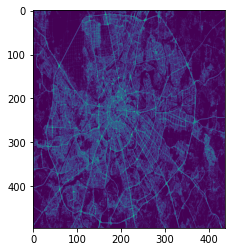

In [16]:
plt.imshow(static[0])

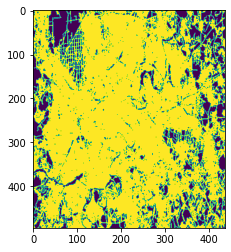

In [17]:
# Get binary mask
mask = np.where(static[0]>0, 1, 0)
plt.imshow(mask)

In [18]:
nonzero = np.count_nonzero(mask)

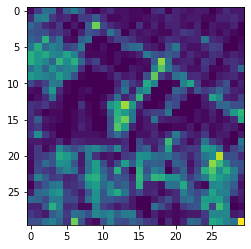

In [15]:
plt.imshow(static[0][110:140, 50:80])

In [11]:
ab = i[0][0].numpy()

In [9]:
import pywt


In [23]:
coeffs[1]

{'aad': array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0.

In [44]:
coeffs[1]['ada'] = np.zeros(coeffs[1]['ada'].shape)

In [46]:
for k in coeffs[1]:
    coeffs[1][k] = np.zeros(coeffs[1]['ada'].shape)

0.0

In [47]:
w = 'db1'
coeffs = pywt.wavedecn(A,wavelet=w, level=1)
#dim1, dim2 = coeffs[-1][0].shape 
for k in coeffs[1]:
    coeffs[1][k] = np.zeros(coeffs[1]['ada'].shape)
#coeffs[-2]=(np.zeros((64,64)),np.zeros((64,64)),np.zeros((64,64)))
#coeffs[-1]=(np.zeros((256,256)),np.zeros((256,256)),np.zeros((128,128)))
#coeffs[-1]=(np.zeros((dim1,dim2)),np.zeros((dim1,dim2)),np.zeros((dim1,dim2)))
#coeffs[-1]=(coeffs[-1][0],coeffs[-1][1],np.zeros((dim1,dim2)))
coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
coeffs_filt = pywt.array_to_coeffs(coeff_arr, coeff_slices, output_format='wavedecn')

recon = pywt.waverecn(coeffs_filt, wavelet=w)

In [48]:
mean_squared_error(recon.flatten(), A.flatten())

216.11456

In [20]:
coeffs[0].shape

(48, 248, 224)

In [12]:
A = i[0][0].numpy()

In [8]:
for idx, i in (enumerate(val_loader)):
    print (i.shape)

AttributeError: 'list' object has no attribute 'shape'

In [10]:
def mse_func(arr1, arr2, div):
    return sum((arr1 - arr2)**2)/div

In [ ]:
### h, w = 256,224
h,w = 496,448
d = 8
trues=[]
preds = [] 
trues = np.zeros((240, 8))
preds = np.zeros((240, 8))
mse=[]
#pixel_x, pixel_y = 101,132#108, 69
pixel_x, pixel_y = 108, 69
t = 0
dim = 1
for idx, i in (enumerate(val_loader)):
    batch_prediction = network(i[0].to('cuda'))
    batch_prediction = batch_prediction.cpu().detach()#.numpy()
    
    pred = model.t_dataset.transform.post_transform(batch_prediction).numpy()
    true = model.t_dataset.transform.post_transform(i[1]).numpy()
    
    #mse.append(mean_squared_error(pred.flatten(), true.flatten()))
    mse.append(mse_func(pred.flatten(), true.flatten(), nonzero))
    #trues.extend(p_true)
    #preds.extend(p_pred)
sum(mse)/len(mse)

- 96.23 overall validation MSE without post transform
| Dataset         |   Overall   | # In stock |
|--------------|-----------|------------|
| Train |       | *7*        |
| Val      |99.07238839467367  | 5234       |

In [38]:
sum((pred.flatten()-true.flatten())**2)/len(pred.flatten())

17.582732774283475

- Total MSE for train/valid
- MSE using division after discounting 0 pixels
- MSE from each of the channels
- MSE from time

In [20]:
true.shape

(2, 6, 495, 436, 8)

In [15]:
### h, w = 256,224
h,w = 496,448
d = 8
trues=[]
preds = [] 
trues = np.zeros((240, 8))
preds = np.zeros((240, 8))
mse=[]
#pixel_x, pixel_y = 101,132#108, 69
pixel_x, pixel_y = 108, 69
t = 0
dim = 1
for idx, i in (enumerate(val_loader)):
    batch_prediction = network(i[0].to('cuda'))
    batch_prediction = batch_prediction.cpu().detach()#.numpy()
    
    pred = model.t_dataset.transform.post_transform(batch_prediction)
    true = model.t_dataset.transform.post_transform(i[1])
    
    p_pred = list(pred[:,t, pixel_x, pixel_y, :].numpy())
    p_true = list(true[:,t, pixel_x, pixel_y, :].numpy())
    trues[idx*2:idx*2+2] = p_true
    preds[idx*2:idx*2+2] = p_pred
    
    #mse.append(mean_squared_error(p_pred, p_true))
    #trues.extend(p_true)
    #preds.extend(p_pred)

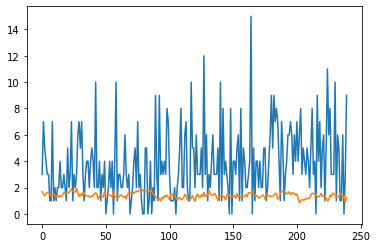

In [27]:

dim = 4
plt.plot(trues[:,dim])
plt.plot(preds[:,dim])

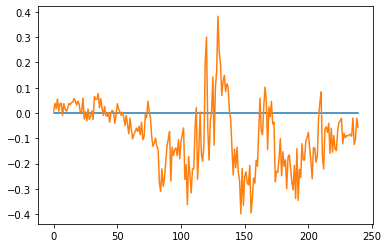

In [54]:
dim = 2
plt.plot(trues[:,dim])
plt.plot(preds[:,dim])

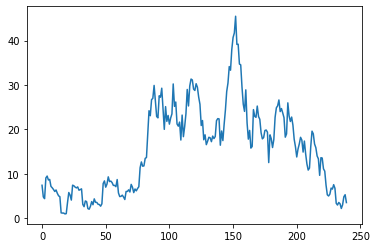

In [24]:
pred.shape

torch.Size([2, 6, 495, 436, 8])

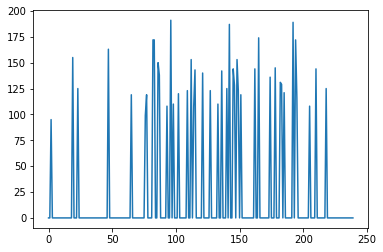

In [21]:
plt.plot(trues)

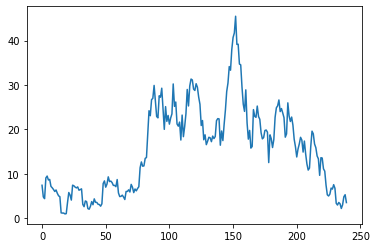

In [22]:
plt.plot(preds)

In [16]:
### h, w = 256,224
h,w = 496,448
d = 8
trues=[]
preds = [] 
mse=[]
pixel_x, pixel_y = 108, 69
t = 0
dim = 2
for idx, i in (enumerate(val_loader)):
    batch_prediction = network(i[0].to('cuda'))
    batch_prediction = batch_prediction.cpu().detach()#.numpy()
    
    pred = model.t_dataset.transform.post_transform(batch_prediction)
    true = model.t_dataset.transform.post_transform(i[1])
    
    p_pred = list(pred[:,t, pixel_x, pixel_y, dim].numpy())
    p_true = list(true[:,t, pixel_x, pixel_y, dim].numpy())
    trues.extend(p_true)
    preds.extend(p_pred)
    if idx==180:
        break

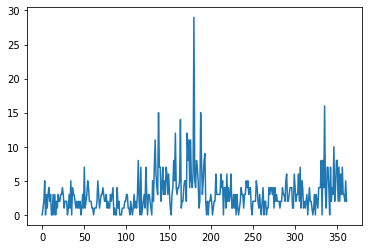

In [17]:
plt.plot(trues)

In [52]:
mean_squared_error(trues,preds)

691.1190884218195

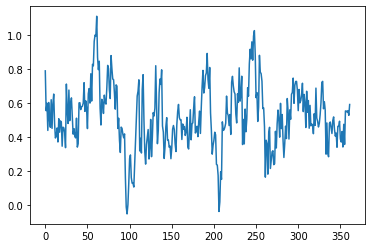

In [19]:
plt.plot(preds)

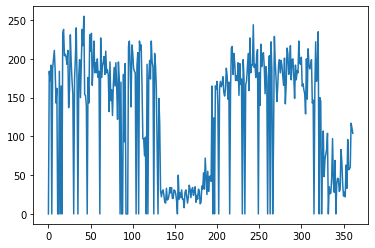

In [13]:
plt.plot(trues)

In [12]:
sum(mse)/len(mse)

102.69133758544922

In [16]:
i[1].shape

torch.Size([2, 48, 496, 448])

In [15]:
model.t_dataset.transform.post_transform(batch_prediction).shape

torch.Size([2, 6, 495, 436, 8])

In [19]:
batch_prediction.shape

(2, 48, 496, 448)

In [ ]:
### h, w = 256,224
h,w = 496,448
pixel = (108, 69)
d = 8
true=[]
preds = [] 
mse=[]
for idx, i in (enumerate(val_loader)):
    batch_prediction = network(i[0].to('cuda'))
    batch_prediction = torch.reshape(batch_prediction, (bs, 6, d, h, w))
    batch_prediction = batch_prediction.cpu().detach().numpy()
    #batch_prediction = batch_prediction[:,:,:,::2,::2]
    
    #batch_prediction = batch_prediction[:,:,::2,:,:]
    
    dat = torch.reshape(i[0], (bs, 12, d, h, w))
    dattrue = torch.reshape(i[1], (bs, 6, d, h, w))
    dat = torch.reshape(i[0], (bs, 12, d, h, w))
    dattrue = torch.reshape(i[1], (bs, 6, d, h, w))
    
    #dattrue = dattrue[:,:,:,::2,::2]
    #dattrue = dattrue[:,:,::2,:,:]
    mse.append(mean_squared_error(dattrue.numpy().flatten(), batch_prediction.flatten()))
    #if idx==6:
    #    break

In [59]:
batch_prediction = model(i[0].to('cuda'))

In [8]:
pre_transform: Callable[[np.ndarray], Union[torch.Tensor, torch_geometric.data.Data]] = configs[model_str].get("pre_transform", None)
post_transform: Callable[[Union[torch.Tensor, torch_geometric.data.Data]], np.ndarray] = configs[model_str].get("post_transform", None)


In [9]:
if post_transform is not None:
    batch_prediction = post_transform(batch_prediction)
    batch_prediction = batch_prediction.cpu().detach().numpy()
else:
    batch_prediction = batch_prediction.cpu().detach().numpy()
batch_prediction = np.clip(batch_prediction, 0, 255)

In [60]:
batch_prediction = torch.reshape(batch_prediction, (1, 6, 8, 496, 448))
batch_prediction = batch_prediction.cpu().detach().numpy()

In [48]:
loss = F.mse_loss
loss(batch_prediction, i[1].to('cuda'))

TypeError: 'int' object is not callable

In [20]:
i[0].shape

torch.Size([1, 96, 496, 448])

In [61]:
dat = torch.reshape(i[0], (1, 12, 8, 496, 448))
dattrue = torch.reshape(i[1], (1, 6, 8, 496, 448))

In [11]:
batch_prediction.shape

(1, 48, 496, 448)

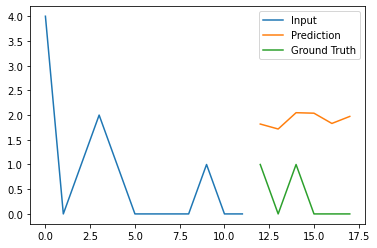

In [62]:
x,y = 495, 434
plt.plot(dat[0,:, 0,x,y], label="Input")
plt.plot([12,13,14,15,16,17],batch_prediction[0,:, 0, x, y], label="Prediction")
plt.plot([12,13,14,15,16,17],dattrue[0,:,0,x,y], label="Ground Truth")
plt.legend()

In [78]:
np.nonzero(dat[0,3,0,:,:])[10:]

tensor([[  1, 295],
        [  1, 296],
        [  1, 305],
        ...,
        [495, 366],
        [495, 376],
        [495, 377]])

In [79]:
max_xy = np.where(dat == dat.max() )

In [80]:
max_xy

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  9,  9, 